In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

In [2]:
def filter_outliers(data, method='iqr', z_threshold=3, iqr_factor=1.5, percentile_range=(5, 95)):
    """
    Filter outliers from the data using various methods.
    
    Parameters:
    -----------
    data : array-like
        The data to filter (typically the current values)
    method : str
        Method for outlier detection: 'iqr', 'zscore', 'percentile', or 'none'
    z_threshold : float
        Z-score threshold for zscore method (default: 3)
    iqr_factor : float
        IQR multiplier for IQR method (default: 1.5)
    percentile_range : tuple
        (lower, upper) percentiles for percentile method
    
    Returns:
    --------
    mask : boolean array
        True for inliers, False for outliers
    """
    if method == 'none':
        return np.ones(len(data), dtype=bool)
    
    elif method == 'zscore':
        z_scores = np.abs(stats.zscore(data))
        return z_scores < z_threshold
    
    elif method == 'iqr':
        Q1 = np.percentile(data, 25)
        Q3 = np.percentile(data, 75)
        IQR = Q3 - Q1
        lower_bound = Q1 - iqr_factor * IQR
        upper_bound = Q3 + iqr_factor * IQR
        return (data >= lower_bound) & (data <= upper_bound)
    
    elif method == 'percentile':
        lower = np.percentile(data, percentile_range[0])
        upper = np.percentile(data, percentile_range[1])
        return (data >= lower) & (data <= upper)
    
    else:
        raise ValueError(f"Unknown method: {method}")

In [3]:
def apply_current_range(currents, current_min=None, current_max=None):
    """
    Apply manual current range limits.
    
    Parameters:
    -----------
    currents : array-like
        Current values
    current_min : float or None
        Minimum current value to include
    current_max : float or None
        Maximum current value to include
    
    Returns:
    --------
    mask : boolean array
        True for values within range
    """
    mask = np.ones(len(currents), dtype=bool)
    
    if current_min is not None:
        mask &= currents >= current_min
    
    if current_max is not None:
        mask &= currents <= current_max
    
    return mask

In [4]:
def plot_voltage_sweep_data_filtered(filename='I-Vx-Vp_m0x3Vn_0Vs_MUXon_50MHz0dBm_2509251107.txt', 
                                    save_pdf=True, 
                                    pdf_filename=None,
                                    outlier_method='iqr',
                                    current_range=None,
                                    **outlier_kwargs):
    """
    Plot current vs V1 curves with outlier filtering.
    
    Parameters:
    -----------
    filename : str
        Path to the data file
    save_pdf : bool
        Whether to save the plot as PDF
    pdf_filename : str
        Name of the PDF file
    outlier_method : str
        Method for outlier detection: 'iqr', 'zscore', 'percentile', or 'none'
    current_range : tuple or None
        (min, max) current values to display
    **outlier_kwargs : dict
        Additional arguments for outlier filtering
    """
    
    # Read the data from file
    try:
        data = np.loadtxt(filename)
        print(f"Data loaded successfully. Shape: {data.shape}")
    except Exception as e:
        print(f"Error reading file: {e}")
        return
    
    # Extract columns
    V2_values = data[:, 0]
    V1_values = data[:, 1]  
    currents = data[:, 2]
    
    # Apply outlier filtering
    outlier_mask = filter_outliers(currents, method=outlier_method, **outlier_kwargs)
    
    # Apply current range if specified
    if current_range is not None:
        range_mask = apply_current_range(currents, current_range[0], current_range[1])
        final_mask = outlier_mask & range_mask
    else:
        final_mask = outlier_mask
    
    # Filter the data
    V2_filtered = V2_values[final_mask]
    V1_filtered = V1_values[final_mask]
    currents_filtered = currents[final_mask]
    
    # Print filtering statistics
    n_removed = len(currents) - len(currents_filtered)
    print(f"Outlier filtering: Removed {n_removed} points ({100*n_removed/len(currents):.1f}%)")
    print(f"Original current range: {currents.min():.6e} to {currents.max():.6e}")
    print(f"Filtered current range: {currents_filtered.min():.6e} to {currents_filtered.max():.6e}")
    
    # Group data by V2 values
    data_by_V2 = defaultdict(lambda: {'V1': [], 'current': []})
    
    for v2, v1, current in zip(V2_filtered, V1_filtered, currents_filtered):
        data_by_V2[v2]['V1'].append(v1)
        data_by_V2[v2]['current'].append(current)
    
    # Sort V2 keys for consistent plotting
    sorted_V2_keys = sorted(data_by_V2.keys())
    
    # Create the plot
    plt.figure(figsize=(12, 8))
    
    # Plot each V2 curve
    colors = plt.cm.viridis(np.linspace(0, 1, len(sorted_V2_keys)))
    
    for i, v2 in enumerate(sorted_V2_keys):
        V1_sorted = np.array(data_by_V2[v2]['V1'])
        current_sorted = np.array(data_by_V2[v2]['current'])
        
        # Sort by V1 to ensure proper line plotting
        sort_indices = np.argsort(V1_sorted)
        V1_sorted = V1_sorted[sort_indices]
        current_sorted = current_sorted[sort_indices]
        
        plt.plot(V1_sorted, current_sorted, '-o', 
                color=colors[i], 
                label=f'V2 = {v2:.2f} V',
                markersize=4,
                linewidth=1.5)
    
    # Formatting
    plt.xlabel('V1 (V)', fontsize=12)
    plt.ylabel('Current (nA)', fontsize=12)
    title = f'Current vs V1 (Filtered: {outlier_method})'
    if current_range:
        title += f'\nCurrent range: [{current_range[0]:.2e}, {current_range[1]:.2e}]'
    plt.title(title, fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    
    # Save as PDF if requested
    if save_pdf:
        if pdf_filename is None:
            base_name = filename.replace('.txt', '').replace('.dat', '')
            pdf_filename = f"{base_name}_filtered_plot.pdf"
        
        plt.savefig(pdf_filename, format='pdf', dpi=300, bbox_inches='tight')
        print(f"Plot saved as: {pdf_filename}")
    
    plt.show()
    
    return data_by_V2

In [5]:


def plot_3d_surface_filtered(filename, 
                             save_pdf=False,
                             elevation=0, 
                             azimuth=-75,
                             outlier_method='percentile',
                             plot_type='surface', # <-- NEW: Choose 'surface' or 'scatter'
                             **outlier_kwargs):
    """
    Create a 3D plot with outlier filtering.
    Can create either a smooth surface plot or a scatter plot.
    """
    try:
        data = np.loadtxt(filename)
    except Exception as e:
        print(f"Could not load data for 3D plot: {e}")
        return

    V2_values = data[:, 0]
    V1_values = data[:, 1]
    currents = data[:, 2]

    # --- Outlier Filtering Logic (from your notebook) ---
    if outlier_method == 'percentile':
        percentile_range = outlier_kwargs.get('percentile_range', (0, 100))
        c_min = np.percentile(currents, percentile_range[0])
        c_max = np.percentile(currents, percentile_range[1])
        mask = (currents >= c_min) & (currents <= c_max)
        print(f"Filtering with {percentile_range[0]}-{percentile_range[1]} percentile range.")
    elif outlier_method == 'iqr':
        iqr_factor = outlier_kwargs.get('iqr_factor', 1.5)
        q1, q3 = np.percentile(currents, [25, 75])
        iqr = q3 - q1
        c_min = q1 - iqr_factor * iqr
        c_max = q3 + iqr_factor * iqr
        mask = (currents >= c_min) & (currents <= c_max)
        print(f"Filtering with IQR method (factor={iqr_factor}).")
    else: # 'range' or default
        current_range = outlier_kwargs.get('current_range', (currents.min(), currents.max()))
        c_min, c_max = current_range
        mask = (currents >= c_min) & (currents <= c_max)
        print(f"Filtering with manual range: {c_min:.2e} to {c_max:.2e} A.")
        
    filtered_v1 = V1_values[mask]
    filtered_v2 = V2_values[mask]
    filtered_currents = currents[mask]
    print(f"Kept {len(filtered_currents)} of {len(currents)} data points after filtering.")
    
    # --- Plotting ---
    fig = plt.figure(figsize=(12, 9))
    ax = fig.add_subplot(111, projection='3d')

    # --- NEW: Conditional logic for plot type ---
    if plot_type == 'surface':
        print("Creating smooth surface plot by gridding the data...")
        # Create a regular grid to interpolate onto
        grid_v1 = np.linspace(filtered_v1.min(), filtered_v1.max(), 100) # 100x100 grid resolution
        grid_v2 = np.linspace(filtered_v2.min(), filtered_v2.max(), 100)
        grid_v1, grid_v2 = np.meshgrid(grid_v1, grid_v2)

        # Interpolate the scattered (but filtered) data onto the grid
        grid_currents = griddata((filtered_v1, filtered_v2), filtered_currents,
                                 (grid_v1, grid_v2), method='cubic')

        # Use plot_surface for a smooth surface
        surf = ax.plot_surface(grid_v1, grid_v2, grid_currents,
                               cmap='viridis',
                               linewidth=0,
                               antialiased=False,
                               vmin=c_min, vmax=c_max) # Use filtered color limits
        
        # Link the color bar to the surface plot
        fig.colorbar(surf, shrink=0.5, aspect=20, label='Current (A)')

    else: # Default to the original scatter plot
        print("Creating scatter plot...")
        scatter = ax.scatter(filtered_v1, filtered_v2, filtered_currents,
                             c=filtered_currents, cmap='viridis', s=10, alpha=0.6,
                             vmin=c_min, vmax=c_max)
        
        # Link the color bar to the scatter plot
        fig.colorbar(scatter, shrink=0.5, aspect=20, label='Current (A)')
    # --- End of new logic ---

    ax.set_xlabel('V1 (Vx)')
    ax.set_ylabel('V2 (Vn)')
    ax.set_zlabel('Current (A)')
    ax.set_title(f'3D {plot_type.capitalize()} Plot: Current vs V1 and V2')
    ax.view_init(elev=elevation, azim=azimuth)

    if save_pdf:
        base_name = filename.replace('.txt', '').replace('.dat', '')
        pdf_filename = f"{base_name}_3D_{plot_type}.pdf"
        plt.savefig(pdf_filename, format='pdf', dpi=300, bbox_inches='tight')
        print(f"3D plot saved as: {pdf_filename}")

    plt.show()

In [6]:
def plot_2d_contour_filtered(filename='I-Vx-Vp_m0x3Vn_0Vs_MUXon_50MHz0dBm_2509251107.txt', 
                            save_pdf=True, 
                            grid_points=200,
                            outlier_method='iqr',
                            current_range=None,
                            use_log_scale=False,
                            colormap='viridis',
                            contour_levels=20,
                            show_datapoints=False,
                            interpolation_method='cubic',
                            **outlier_kwargs):
    """
    Creates a 2D contour plot with outlier filtering and enhanced visualization options.
    
    Parameters:
    -----------
    filename : str
        Path to the data file
    save_pdf : bool
        Whether to save the plot as PDF
    grid_points : int
        Resolution of the interpolation grid
    outlier_method : str
        Method for outlier detection: 'iqr', 'zscore', 'percentile', or 'none'
    current_range : tuple or None
        (min, max) current values to display
    use_log_scale : bool
        Whether to use logarithmic scale for current values
    colormap : str
        Colormap for visualization
    contour_levels : int or array-like
        Number of contour levels or specific levels
    show_datapoints : bool
        Whether to overlay actual data points
    interpolation_method : str
        Method for griddata: 'nearest', 'linear', or 'cubic'
    **outlier_kwargs : dict
        Additional arguments for outlier filtering
    """
    
    try:
        data = np.loadtxt(filename)
        print(f"Data loaded successfully for 2D plot. Shape: {data.shape}")
    except Exception as e:
        print(f"Could not load data: {e}")
        return
    
    V2_values = data[:, 0]
    V1_values = data[:, 1]
    currents = data[:, 2]
    
    # Apply outlier filtering
    outlier_mask = filter_outliers(currents, method=outlier_method, **outlier_kwargs)
    
    # Apply current range if specified
    if current_range is not None:
        range_mask = apply_current_range(currents, current_range[0], current_range[1])
        final_mask = outlier_mask & range_mask
    else:
        final_mask = outlier_mask
    
    # Filter the data
    V1_filtered = V1_values[final_mask]
    V2_filtered = V2_values[final_mask]
    currents_filtered = currents[final_mask]
    
    # Apply log scale if requested
    if use_log_scale:
        min_positive = np.min(np.abs(currents_filtered[currents_filtered != 0]))
        currents_plot = np.log10(np.abs(currents_filtered) + min_positive)
        colorbar_label = 'log10|Current| (A)'
    else:
        currents_plot = currents_filtered
        colorbar_label = 'Current (A)'
    
    # Print filtering statistics
    n_removed = len(currents) - len(currents_filtered)
    print(f"Outlier filtering: Removed {n_removed} points ({100*n_removed/len(currents):.1f}%)")
    print(f"Final current range: {currents_filtered.min():.6e} to {currents_filtered.max():.6e}")
    
    # Create a regular grid to interpolate onto
    grid_v1 = np.linspace(V1_filtered.min(), V1_filtered.max(), grid_points)
    grid_v2 = np.linspace(V2_filtered.min(), V2_filtered.max(), grid_points)
    grid_v1, grid_v2 = np.meshgrid(grid_v1, grid_v2)
    
    # Interpolate the scattered data onto the regular grid
    grid_currents = griddata((V1_filtered, V2_filtered), currents_plot, 
                            (grid_v1, grid_v2), method=interpolation_method)
    
    # Create the plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # --- First subplot: Filled contour (density map) ---
    if isinstance(contour_levels, int):
        contour1 = ax1.contourf(grid_v1, grid_v2, grid_currents, 
                               levels=contour_levels, cmap=colormap, extend='both')
    else:
        contour1 = ax1.contourf(grid_v1, grid_v2, grid_currents, 
                               levels=contour_levels, cmap=colormap, extend='both')
    
    # Add contour lines
    contour_lines1 = ax1.contour(grid_v1, grid_v2, grid_currents, 
                                levels=10, colors='black', alpha=0.3, linewidths=0.5)
    ax1.clabel(contour_lines1, inline=True, fontsize=8, fmt='%.2e')
    
    # Overlay actual data points if requested
    if show_datapoints:
        ax1.scatter(V1_filtered, V2_filtered, c='red', s=2, alpha=0.3, marker='.')
    
    # Add colorbar
    cbar1 = plt.colorbar(contour1, ax=ax1)
    cbar1.set_label(colorbar_label, fontsize=12, fontweight='bold')
    
    # Labels and title for first subplot
    ax1.set_xlabel('V1 (V)', fontsize=14, fontweight='bold')
    ax1.set_ylabel('V2 (V)', fontsize=14, fontweight='bold')
    title1 = f'2D Contour Map (Filled)\nFiltered: {outlier_method}'
    if current_range:
        title1 += f'\nRange: [{current_range[0]:.2e}, {current_range[1]:.2e}]'
    ax1.set_title(title1, fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.2)
    
    # --- Second subplot: Line contour plot ---
    # Create custom levels for better visualization
    if currents_plot.min() < 0 and currents_plot.max() > 0:
        # If data spans zero, create levels on both sides
        neg_levels = np.linspace(currents_plot.min(), 0, contour_levels//2)
        pos_levels = np.linspace(0, currents_plot.max(), contour_levels//2)
        custom_levels = np.concatenate([neg_levels[:-1], pos_levels])
    else:
        custom_levels = np.linspace(currents_plot.min(), currents_plot.max(), contour_levels)
    
    contour2 = ax2.contour(grid_v1, grid_v2, grid_currents, 
                          levels=custom_levels, cmap=colormap, linewidths=2)
    ax2.clabel(contour2, inline=True, fontsize=8, fmt='%.2e')
    
    # Fill background with subtle colors
    contourf2 = ax2.contourf(grid_v1, grid_v2, grid_currents, 
                            levels=custom_levels, cmap=colormap, alpha=0.3)
    
    # Overlay actual data points if requested
    if show_datapoints:
        scatter2 = ax2.scatter(V1_filtered, V2_filtered, c=currents_plot, 
                             cmap=colormap, s=10, alpha=0.6, edgecolors='k', linewidth=0.1)
    
    # Add colorbar
    cbar2 = plt.colorbar(contourf2, ax=ax2)
    cbar2.set_label(colorbar_label, fontsize=12, fontweight='bold')
    
    # Labels and title for second subplot
    ax2.set_xlabel('V1 (V)', fontsize=14, fontweight='bold')
    ax2.set_ylabel('V2 (V)', fontsize=14, fontweight='bold')
    ax2.set_title(f'2D Contour Map (Lines)\nInterpolation: {interpolation_method}', 
                 fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.2)
    
    plt.tight_layout()
    
    # Save the figure if requested
    if save_pdf:
        base_name = filename.replace('.txt', '').replace('.dat', '')
        pdf_filename = f"{base_name}_2D_contour_filtered.pdf"
        plt.savefig(pdf_filename, format='pdf', dpi=300, bbox_inches='tight')
        print(f"2D contour plot saved as: {pdf_filename}")
    
    plt.show()

In [7]:
def analyze_data_statistics(filename='I-Vx-Vp_m0x3Vn_0Vs_MUXon_50MHz0dBm_2509251107.txt'):
    """
    Analyze and print detailed statistics about the data to help determine
    appropriate filtering parameters.
    """
    try:
        data = np.loadtxt(filename)
        print(f"Data loaded successfully. Shape: {data.shape}")
    except Exception as e:
        print(f"Error loading data: {e}")
        return
    
    V2_values = data[:, 0]
    V1_values = data[:, 1]
    currents = data[:, 2]
    
    print("\n" + "="*60)
    print("DATA STATISTICS")
    print("="*60)
    
    # Basic statistics
    print("\nBasic Statistics:")
    print(f"  V1 range: {V1_values.min():.3f} to {V1_values.max():.3f} V")
    print(f"  V2 range: {V2_values.min():.3f} to {V2_values.max():.3f} V")
    print(f"  Current range: {currents.min():.6e} to {currents.max():.6e} A")
    
    # Current statistics
    print("\nCurrent Statistics:")
    print(f"  Mean: {currents.mean():.6e} A")
    print(f"  Median: {np.median(currents):.6e} A")
    print(f"  Std Dev: {currents.std():.6e} A")
    
    # Percentiles
    percentiles = [1, 5, 10, 25, 50, 75, 90, 95, 99]
    print("\nCurrent Percentiles:")
    for p in percentiles:
        val = np.percentile(currents, p)
        print(f"  {p:3d}%: {val:.6e} A")
    
    # IQR analysis
    Q1 = np.percentile(currents, 25)
    Q3 = np.percentile(currents, 75)
    IQR = Q3 - Q1
    print("\nIQR Analysis:")
    print(f"  Q1 (25%): {Q1:.6e} A")
    print(f"  Q3 (75%): {Q3:.6e} A")
    print(f"  IQR: {IQR:.6e} A")
    print(f"  Lower fence (Q1-1.5*IQR): {Q1-1.5*IQR:.6e} A")
    print(f"  Upper fence (Q3+1.5*IQR): {Q3+1.5*IQR:.6e} A")
    
    # Count outliers using different methods
    print("\nOutlier Detection (potential outliers):")
    
    # IQR method
    iqr_outliers = (currents < Q1-1.5*IQR) | (currents > Q3+1.5*IQR)
    print(f"  IQR method (1.5x): {iqr_outliers.sum()} points ({100*iqr_outliers.sum()/len(currents):.1f}%)")
    
    # Z-score method
    z_scores = np.abs(stats.zscore(currents))
    z3_outliers = z_scores > 3
    z2_outliers = z_scores > 2
    print(f"  Z-score > 3: {z3_outliers.sum()} points ({100*z3_outliers.sum()/len(currents):.1f}%)")
    print(f"  Z-score > 2: {z2_outliers.sum()} points ({100*z2_outliers.sum()/len(currents):.1f}%)")
    
    # Distribution shape
    print("\nDistribution Shape:")
    print(f"  Skewness: {stats.skew(currents):.3f}")
    print(f"  Kurtosis: {stats.kurtosis(currents):.3f}")
    
    print("\n" + "="*60)
    
    return {
        'V1_range': (V1_values.min(), V1_values.max()),
        'V2_range': (V2_values.min(), V2_values.max()),
        'current_range': (currents.min(), currents.max()),
        'percentiles': {p: np.percentile(currents, p) for p in percentiles},
        'IQR_bounds': (Q1-1.5*IQR, Q3+1.5*IQR)
    }

Data loaded successfully. Shape: (400, 3)

DATA STATISTICS

Basic Statistics:
  V1 range: -0.700 to -0.505 V
  V2 range: -0.450 to -0.000 V
  Current range: 2.090000e-03 to 7.158640e+00 A

Current Statistics:
  Mean: 1.045977e-01 A
  Median: 3.014000e-03 A
  Std Dev: 5.957240e-01 A

Current Percentiles:
    1%: 2.175980e-03 A
    5%: 2.253950e-03 A
   10%: 2.317600e-03 A
   25%: 2.518750e-03 A
   50%: 3.014000e-03 A
   75%: 8.744500e-03 A
   90%: 5.435000e-02 A
   95%: 2.027708e-01 A
   99%: 3.185939e+00 A

IQR Analysis:
  Q1 (25%): 2.518750e-03 A
  Q3 (75%): 8.744500e-03 A
  IQR: 6.225750e-03 A
  Lower fence (Q1-1.5*IQR): -6.819875e-03 A
  Upper fence (Q3+1.5*IQR): 1.808312e-02 A

Outlier Detection (potential outliers):
  IQR method (1.5x): 75 points (18.8%)
  Z-score > 3: 6 points (1.5%)
  Z-score > 2: 9 points (2.2%)

Distribution Shape:
  Skewness: 8.440
  Kurtosis: 78.957

Data loaded successfully for 2D plot. Shape: (400, 3)
Outlier filtering: Removed 40 points (10.0%)
Final curr

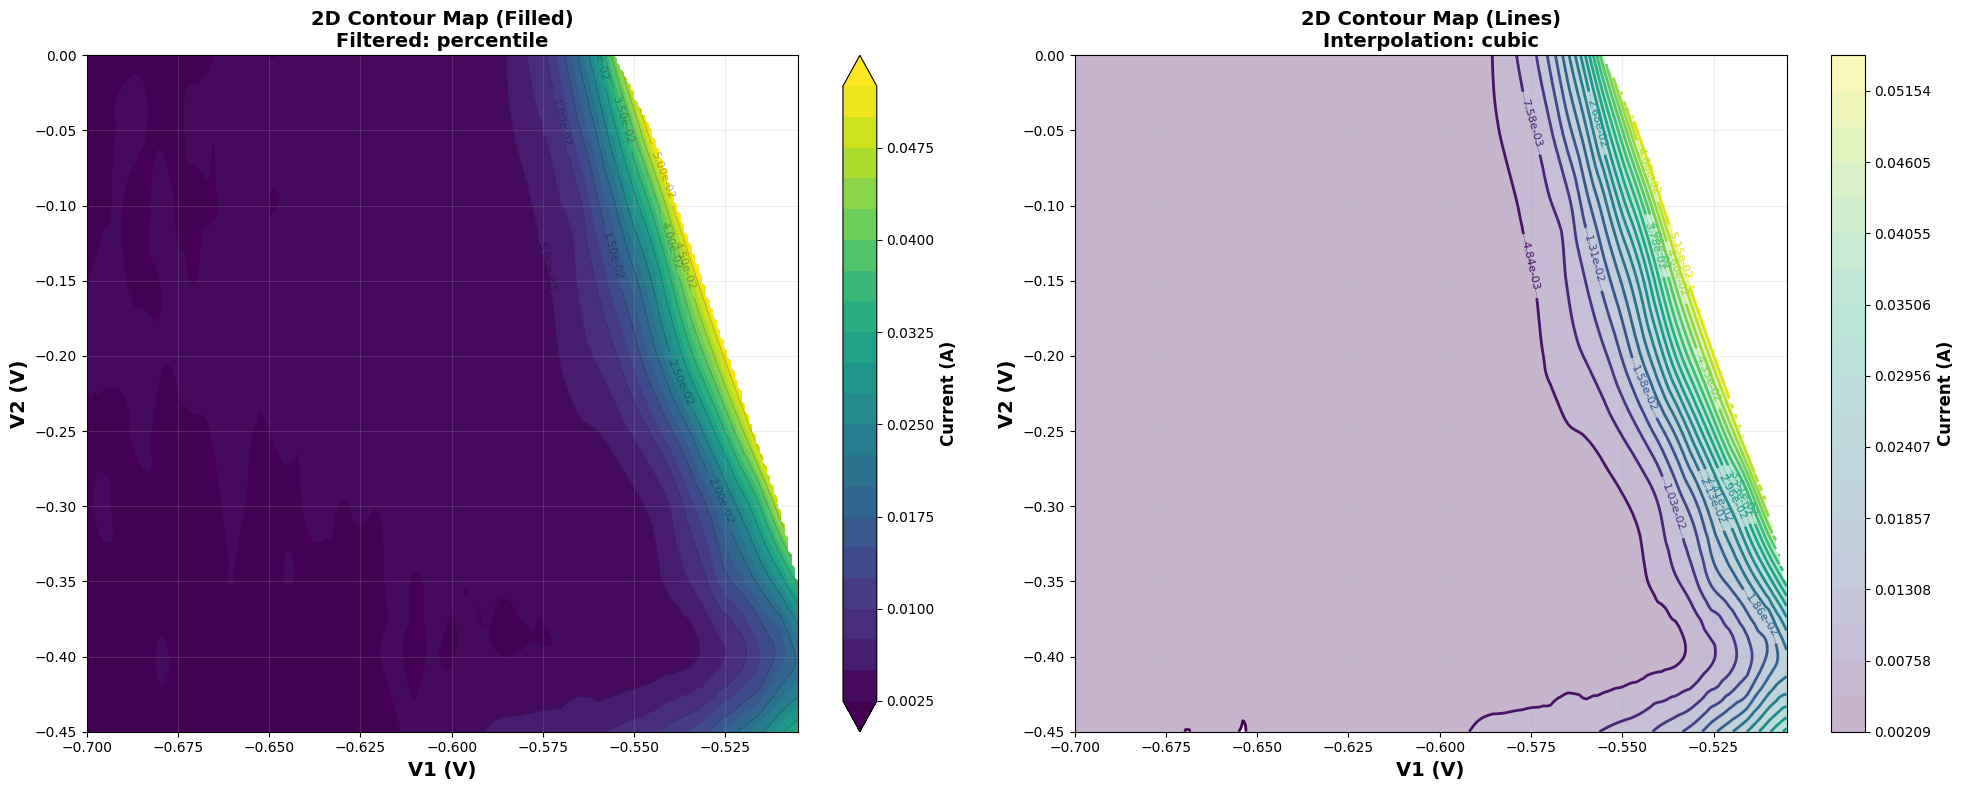

Filtering with 0-100 percentile range.
Kept 400 of 400 data points after filtering.
Creating smooth surface plot by gridding the data...


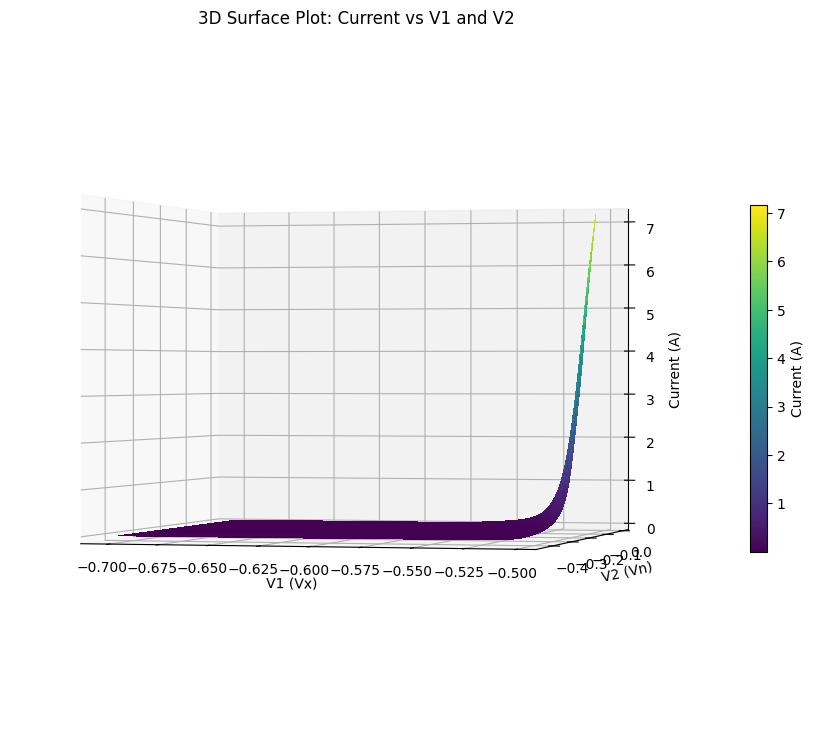

Data loaded successfully. Shape: (400, 3)
Outlier filtering: Removed 75 points (18.8%)
Original current range: 2.090000e-03 to 7.158640e+00
Filtered current range: 2.090000e-03 to 1.795600e-02
Plot saved as: I-Vx-Vp_m0x3Vn_0Vs_MUXon_50MHz0dBm_2509251107_filtered_plot.pdf


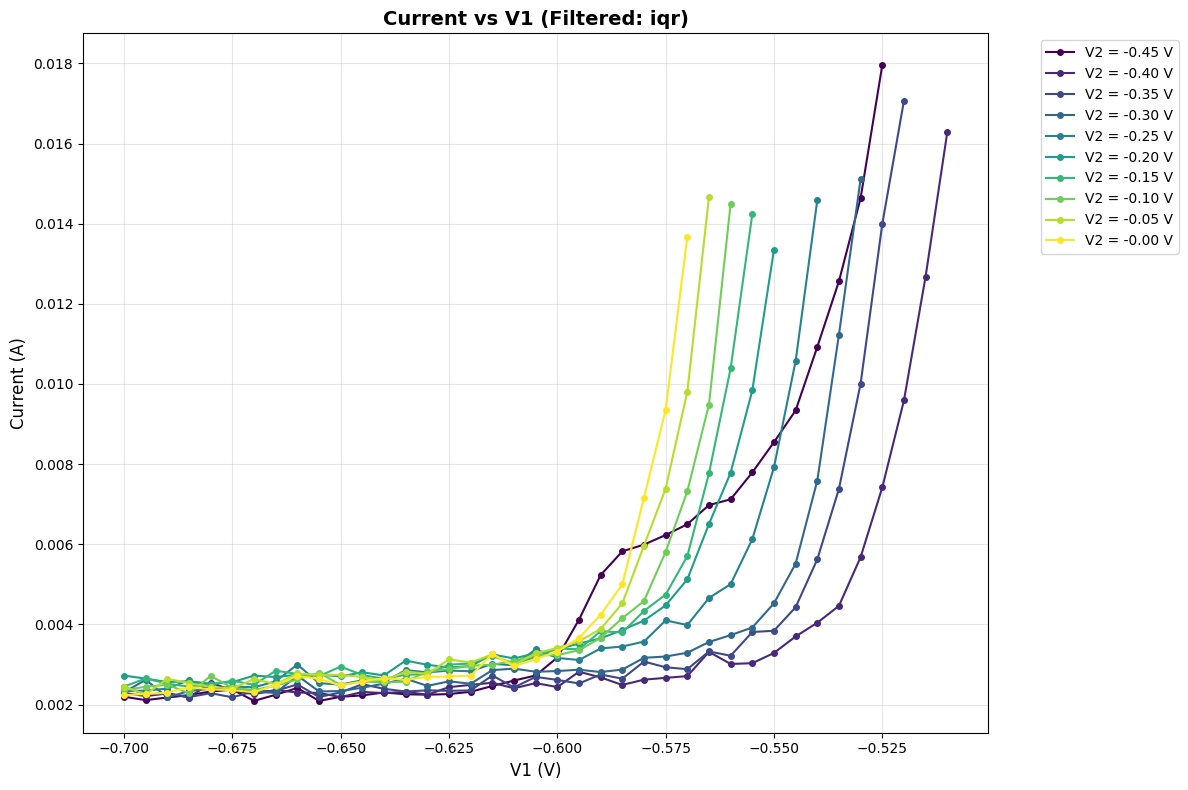

In [8]:
# Example usage functions
if __name__ == "__main__":
    # Simple test example - copy and run this
    filename = 'I-Vx-Vp_m0x3Vn_0Vs_MUXon_50MHz0dBm_2509251107.txt'

# Just run the analysis first
    analyze_data_statistics(filename)

# Then try a simple 2D contour plot with filtering
    plot_2d_contour_filtered(
        filename,
        outlier_method='percentile',
        percentile_range=(0,90),
        save_pdf=True
    )

##
    plot_3d_surface_filtered(filename, plot_type='surface')
# Or try a 3D plot
    # plot_3d_surface_filtered(
    #     filename,
    #     outlier_method='iqr',
    #     iqr_factor=1.5,
    #     save_pdf=True
    # )
#plot iv
    plot_voltage_sweep_data_filtered(
        filename,
        outlier_method='iqr',
        iqr_factor=1.5,
        save_pdf=True
    )